## Python Notebook to interact with gym-battery and battery-agent

This python notebook is a working document to interact with and test the environment and the agent.

Note: In order for this to work, gym-battery needs to be installed as a package, using pip install -e gym-battery from wherever gym-battery exists.

The ipython notebook should exist in battery dispatch by default and should be ableto access those resources so it does not necessarily need to be build/installed using pip.

In [ ]:
import gym
import gym_battery 
import numpy as np

In [ ]:
env = gym.make('gym_battery:battery-v0', **{'N_actions': 7})

In [3]:
env.set_standard_system()

setting the standard system, A10S Med busines large usage with a 2,000kW/10,000kWh battery


In [4]:
# Show the possible action mapping the agent can take
env.action_mapping

{0: -1000.0,
 1: -666.6666666666666,
 2: -333.3333333333333,
 3: 0.0,
 4: 333.3333333333333,
 5: 666.6666666666666,
 6: 1000.0}

In [5]:
# Set how to structure the environment. 'count_days' will generate the a single day as an episode. THe number of days
# given indicates how many differnet days to use.
# This needs to be changed so that it generates LONGER episodes, not DIFFERENT episodes, but this hasn't been done yet.
env.episode_type = 'count_days'
env.run_N_episodes = 1


In [6]:
# Get the do-nothing value for taking no action
def dict_key_by_val(d, val):
    for k in d.keys():
        if d[k] == val:
            return k
    raise ValueError("value not found in dictionary")
    
act0 = dict_key_by_val(env.action_mapping, 0)
act0

3

In [7]:
''' Set up the agent and the discretizer.'''
from batterydispatch.agent.agents import MonteCarloAgent
from batterydispatch.agent.discretizers import Box_Discretizer

from batterydispatch.agent.policies import do_nothing
agent = MonteCarloAgent()
agent.set_policy(do_nothing, {'do_nothing_action': act0})

# Note, you can change the size of the state sapce by changing the number of buckets, below
agent.set_discretizer(Box_Discretizer(env.observation_space, N=[6, 4, 25, 25]))
agent.learning_rate = 0.05 # used for the updates of the Q estimates
agent.subtype = 'off-policy' # Setup the MC agent for off-policy learning

In [8]:
agent.discretizer.buckets


[array([ 0.,  4.,  8., 12., 16., 20.]),
 array([   0., 2500., 5000., 7500.]),
 array([  300.,   936.,  1572.,  2208.,  2844.,  3480.,  4116.,  4752.,
         5388.,  6024.,  6660.,  7296.,  7932.,  8568.,  9204.,  9840.,
        10476., 11112., 11748., 12384., 13020., 13656., 14292., 14928.,
        15564.]),
 array([  300.,   976.,  1652.,  2328.,  3004.,  3680.,  4356.,  5032.,
         5708.,  6384.,  7060.,  7736.,  8412.,  9088.,  9764., 10440.,
        11116., 11792., 12468., 13144., 13820., 14496., 15172., 15848.,
        16524.])]

## Plot the day of data that we will be trying to learn from

2011-03-06
76
-410081.10000000003


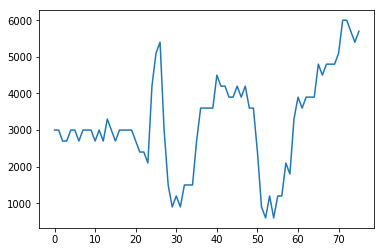

In [9]:

done = False
state = env.reset()
i = 0
while not done:
    i+=1
    action = agent.get_action(state, env.action_space, 0)
    _,reward,done, details = env.step(action)

from matplotlib import pyplot as plt
plt.plot(env.grid_flow.net_flow)
try:
    print(list(env.grid_flow.start_date)[0])
except:
    pass
print(i)
print(reward)
default_reward = reward
plt.show()


## Shrink the state space for testing purposes.

In the following section, for testing, we redefine the state space so that it is more relevant to the specific day being modeled, and significantly reduce the size of the state space to try and improve learning.

In [10]:
from gym.spaces import Box
import numpy as np

state_size = [4, 3, 6, 8]

env.observation_space = Box(np.array([0, 0, 3000, 1000]),np.array([24, env.bus.battery.capacity, 7000, 6500]))
agent.set_discretizer(Box_Discretizer(env.observation_space, N=state_size))
agent.actions = env.action_space
agent.initialize_state_actions(default=default_reward,
                              do_nothing_action = act0,
                              do_nothing_bonus = 100)


In [11]:
def multiply_all(l):
    total = 1
    for i in l:
        total *= i
    return total

print("Total number of states: {}".format(multiply_all(state_size)))
agent.discretizer.buckets

Total number of states: 576


[array([ 0.,  6., 12., 18.]),
 array([   0.        , 3333.33333333, 6666.66666667]),
 array([3000.        , 3666.66666667, 4333.33333333, 5000.        ,
        5666.66666667, 6333.33333333]),
 array([1000. , 1687.5, 2375. , 3062.5, 3750. , 4437.5, 5125. , 5812.5])]

In [12]:
# We then initialize the agent state-action estimates, based on the original billing period.
# We also give the do_nothing action a small bonus of 100, in order to prevent the agent from arbitrarily taking action.
agent.initialize_state_actions(default=default_reward,
                              do_nothing_action = act0,
                              do_nothing_bonus = 100)

## Set up the function to run the episodes, and run episodes until convergence.

In [13]:
# This function runs the actual episodes, repeatedly, until policy converges.

from IPython.display import clear_output
# initial state
from batterydispatch.agent.agents import PolicyConvergedError
def run_to_convergence(random_charge = True):
    possible_actions = list(env.action_mapping.keys())
    converged=False
    done=False
    i = 0
    eps = 0
    while not converged:
        state = env.reset(random_charge=random_charge)

        i += 1
        eps+=1
        if i > 50:
            i = 0
            clear_output()

        while not done:
            action = agent.get_action(state, possible_actions, 0.25)
            #print(action)
            old_state = state.copy()
            state, reward, done, details = env.step(action)
            
            #agent.observe_sars(old_state, action, reward, state)
        try:
            agent.end_episode(reward)
        except PolicyConvergedError:
            converged = True

        try:
            new_demand = max(env.grid_flow.net_flow)
            orig_demand = max(env.grid_flow.load)
        except AttributeError:
            new_demand = "???"
            orig_demand = "???"

        done = False


        print(f"Current reward of {int(reward)} / {int(default_reward)}, {new_demand} / {orig_demand}, patience={agent.patience_counter}")
        #converged = agent.check_policy_convergence(False)
    print("Converged!")
    return eps

In [14]:
# We then set the final parameters guiding the episodes: The agents proclivity for random actions, 
# the number of episodes without a policy change before we can say we've converge.
agent.set_greedy_policy(eta=0.2)
agent.patience = 100


In [15]:
%%time
agent.patience_counter = 0

eps = run_to_convergence(random_charge = False)
eps

Current reward of -401012 / -410081, 5500.0 / 6000.0, patience=58
Current reward of -425873 / -410081, 6700.0 / 6000.0, patience=59
Current reward of -417573 / -410081, 6366.666666666667 / 6000.0, patience=60
Current reward of -419274 / -410081, 6366.666666666667 / 6000.0, patience=61
Current reward of -405192 / -410081, 5766.666666666667 / 6000.0, patience=62
Current reward of -425640 / -410081, 6666.666666666667 / 6000.0, patience=63
Current reward of -416694 / -410081, 6333.333333333333 / 6000.0, patience=64
Current reward of -427468 / -410081, 6666.666666666667 / 6000.0, patience=65
Current reward of -417635 / -410081, 6333.333333333333 / 6000.0, patience=66
Current reward of -427209 / -410081, 6700.0 / 6000.0, patience=67
Current reward of -409940 / -410081, 6000.0 / 6000.0, patience=68
Current reward of -411417 / -410081, 6066.666666666667 / 6000.0, patience=69
Current reward of -410091 / -410081, 5800.0 / 6000.0, patience=70
Current reward of -398416 / -410081, 5400.0 / 6000.0, 

In [16]:
print(f"The agent converged after {eps} episodes")

The agent converged after 5092 episodes


Agent has taken between 10 and 30 minutes, and between 700 and 2262 episodes, to converge on day 1. Optimal policy:
Current reward of -397414.125 / -406791.825, 5600.0 / 6000.0, patience=21

For 2 days, agent took 5 hours 8 minutes, and converged after 21200 episodes.

## Then we allow the agent to take entirely greedy actions and run the algorithm to see how much the agent learned. 

In [ ]:
agent.set_greedy_policy(eta=0)
    
state = env.reset(random_charge=False)
done = False
print(state)
while not done:
    action = agent.get_action(state, list(env.action_mapping.keys()), 0.25)
    #print(state)
    #action = int(input("action:"))

    #print(action)
    state, reward, done, details = env.step(action)

try:
    new_demand = max(env.grid_flow.net_flow)
    orig_demand = max(env.grid_flow.load)
except AttributeError:
    new_demand = "???"
    orig_demand = "???"
    
    env.grid_flow['final_reward'] = reward
    env.grid_flow['original_reward'] = default_reward


print(f"Current reward of {reward} / {default_reward}, {new_demand} / {orig_demand}, patience={agent.patience_counter}")




In [ ]:
# If desired we can output the results to the clipboard for further analysis
env.grid_flow.to_clipboard()